# 数据预处理

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from time import time
import datetime
   
train_data = pd.read_csv("train.csv",index_col = 0)
test_data = pd.read_csv("test.csv",index_col = 0)
data = pd.concat([train_data,test_data],ignore_index=True) #ignore_index 索引拼接

In [24]:
#删除同预测的y没有关系的列
data.drop(["id"],inplace=True,axis=1)

In [25]:
data.loc[data["Arrival Delay in Minutes"].isnull(),"Arrival Delay in Minutes"]=0 #填补0
#将二分类变量转换为数值型变量
data["Gender"] = (data["Gender"]== "Male").astype("int")
customer_type = data["Customer Type"].unique().tolist()
data["Customer Type"] = data["Customer Type"].apply(lambda x: customer_type.index(x))
type_of_travel = data["Type of Travel"].unique().tolist()
data["Type of Travel"] = data["Type of Travel"].apply(lambda x: type_of_travel.index(x))
data_class = train_data["Class"].unique().tolist()
data["Class"] = data["Class"].apply(lambda x: data_class .index(x))
satisfaction = data["satisfaction"].unique().tolist()
data["satisfaction"]= data["satisfaction"].apply(lambda x: satisfaction.index(x))

In [26]:
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,0,13,0,0,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,1,1,25,1,1,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,0,0,26,1,1,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,0,0,25,1,1,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,1,0,61,1,1,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [27]:
x = data.iloc[:,data.columns != "satisfaction"]
y = data.iloc[:,data.columns == "satisfaction"]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(x,y,test_size=0.3)
#修正测试集和训练集的索引
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])


In [28]:
#Xtrain = torch.tensor(np.array(Xtrain))
std = StandardScaler()
Xtrain= std.fit_transform(Xtrain)
Xtest= std.fit_transform(Xtest)

In [29]:
x_train, y_train, x_valid, y_valid= map(
    torch.tensor, (Xtrain, np.array(Ytrain),Xtest,np.array(Ytest))
)
y_train=y_train.reshape([-1])
y_valid =y_valid.reshape([-1])
bs=1000
#先构造tensorDataset
#然后采用DataLoader指定batch_size去取数据，不用再去写取数据的方法，shuffle=True表示洗牌
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
print(len(train_ds))

90916


In [30]:
def tarin_model(model):
    epochs =300
    device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
    learning_rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_func = F.cross_entropy
    model = model.double()
    model = model.to(device)
    train_acc=[]
    vaild_acc=[]
    loss_train=[]
    loss_vaild = []
    for epoch in range(epochs):
        train_total_correct = 0
        vaild_total_correct = 0
            
        epoch += 1
        for xb, yb in train_dl:
            xb= xb.to(device)
            yb= yb.to(device)
            out = model(xb)
            out.to(device)
            train_loss = loss_func(out, yb)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        if epoch%10==0:
            for xb, yb in train_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                out1 =  model(xb)
                pred1 = out1.argmax(dim=1)
                train_correct = pred1.eq(yb).sum()
                train_total_correct +=train_correct
            total_num = len(train_ds)
            trainacc = train_total_correct/total_num
            for xv, yv in valid_dl:
                xv = xv.to(device)
                yv = yv.to(device)
                out2 =  model(xv)
                valid_loss = loss_func(out2, yv)
                pred2 = out2.argmax(dim=1)
                valid_correct = pred2.eq(yv).sum()
                vaild_total_correct +=valid_correct
            total_num = len(valid_ds)
            validacc = vaild_total_correct/total_num
            print('epoch {},训练集 loss：{},训练集acc: {},验证集 loss：{},验证集 acc: {}'.format(epoch, train_loss.item(),trainacc,valid_loss.item(),validacc))
            train_acc.append(trainacc)
            vaild_acc.append(validacc)
            loss_train.append(train_loss.item())
            loss_vaild.append(valid_loss.item())
        
    return  train_acc,vaild_acc,loss_train,loss_vaild



In [269]:
def draw_plot(epoch,train,vaild,flag):
#     decrease=np.linspace(0,300,300)
#     xticks=np.linspace(0,300,10)
#     print(xticks)
    plt.plot((range(0,300,10)),train,color="red",label="train")
    plt.plot((range(0,300,10)),vaild,color="blue",label="vaild")
    plt.xlabel('epoch',fontsize=16)
    plt.ylabel(flag, fontsize=16)
    plt.xticks(range(20,320,20),fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(prop={"family": "Times New Roman", "size": 13})
    plt.show()
# def draw_plot(epoch,acc_train,acc_vaild,loss_train,loss_vaild):
  
#     fig, axes = plt.subplots(1,2,figsize=(28,10))
#     axes[0].set_title("Loss")
#     axes[0].plot(range(10,310,10),loss_train,color="red",label="train")
#     axes[0].plot(range(10,310,10),loss_vaild,color="blue",label="test")
#     axes[0].set_xlabel('epoch')
#     axes[0].set_ylabel('loss')
#     axes[0].set_xticks(range(30,330,30))
#     axes[0].legend()
    
#     axes[1].set_title("Accuracy")
#     axes[1].plot(range(10,310,10),acc_train,color="red",label="train")
#     axes[1].plot(range(10,310,10),acc_vaild,color="blue",label="test")
#     axes[1].set_xlabel('epoch')
#     axes[1].set_ylabel('accuracy')
#     axes[1].set_xticks(range(30,330,30))
#     axes[1].legend()
#     plt.show()
   

# 人工神经网络

In [32]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer  = nn.Linear(22,2)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.layer(x))
        #print(x)
        x = self.out(x)
        #print(x)
        return x


In [36]:
model =ANN()
time0 = time()
ANN_train_acc,ANN_vaild_acc,ANN_loss_train,ANN_loss_vaild=tarin_model(model)
ANN_time = datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f")
print(ANN_time)

epoch 10,训练集 loss：0.6231956514471283,训练集acc: 0.8189207911491394,验证集 loss：0.6288076336242062,验证集 acc: 0.8185760974884033
epoch 20,训练集 loss：0.5892007741471782,训练集acc: 0.8361454606056213,验证集 loss：0.5957709408816784,验证集 acc: 0.8370034098625183
epoch 30,训练集 loss：0.5820835947218976,训练集acc: 0.8459126949310303,验证集 loss：0.5809446252457938,验证集 acc: 0.8460630178451538
epoch 40,训练集 loss：0.5680750527270116,训练集acc: 0.8523252010345459,验证集 loss：0.5720019516290616,验证集 acc: 0.8528128266334534
epoch 50,训练集 loss：0.5652604868405184,训练集acc: 0.8574618101119995,验证集 loss：0.5660554083595992,验证集 acc: 0.8576378226280212
epoch 60,训练集 loss：0.5607976828090615,训练集acc: 0.8605526089668274,验证集 loss：0.561765963974029,验证集 acc: 0.8605379462242126
epoch 70,训练集 loss：0.5546193370505839,训练集acc: 0.863335371017456,验证集 loss：0.5585822727168767,验证集 acc: 0.8632070422172546
epoch 80,训练集 loss：0.5552124585674765,训练集acc: 0.8648532629013062,验证集 loss：0.5561411452061663,验证集 acc: 0.8651319146156311
epoch 90,训练集 loss：0.5585013687257516,训练集ac

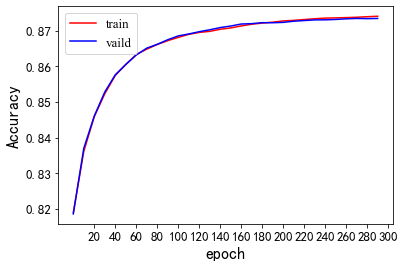

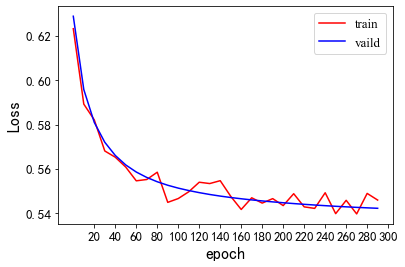

In [270]:
#draw_plot(300,train_acc,vaild_acc,loss_train,loss_vaild)
draw_plot(300,ANN_train_acc,ANN_vaild_acc,'Accuracy')
draw_plot(300,ANN_loss_train,ANN_loss_vaild,'Loss')

# 深度神经网络

In [16]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input  = nn.Linear(22, 256)
        self.hidden1  = nn.Linear(256, 128)
        self.hidden2  = nn.Linear(128, 2)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.hidden1(F.relu(x))
        x = self.hidden2(F.relu(x))
        x = self.out(x)
        return x

In [37]:
model =DNN()
time1 = time()
DNN_train_acc,DNN_vaild_acc,DNN_loss_train,DNN_loss_vaild=tarin_model(model)
DNN_time = datetime.datetime.fromtimestamp(time()-time1).strftime("%M:%S:%f")
print(DNN_time)

epoch 10,训练集 loss：0.5438030258605465,训练集acc: 0.835859477519989,验证集 loss：0.5407230080373288,验证集 acc: 0.8341032862663269
epoch 20,训练集 loss：0.46846979035674813,训练集acc: 0.8588037490844727,验证集 loss：0.4713845115072008,验证集 acc: 0.8564572334289551
epoch 30,训练集 loss：0.44288716843076503,训练集acc: 0.8703088760375977,验证集 loss：0.45086714480314805,验证集 acc: 0.868878960609436
epoch 40,训练集 loss：0.4470887594796791,训练集acc: 0.8790202140808105,验证集 loss：0.4398732038302414,验证集 acc: 0.8774766325950623
epoch 50,训练集 loss：0.4324752826183636,训练集acc: 0.8852787017822266,验证集 loss：0.4326038402262184,验证集 acc: 0.8837901949882507
epoch 60,训练集 loss：0.431047024882871,训练集acc: 0.8896563649177551,验证集 loss：0.42751015858942665,验证集 acc: 0.888640820980072
epoch 70,训练集 loss：0.416518880205565,训练集acc: 0.8930221199989319,验证集 loss：0.42380223149566526,验证集 acc: 0.8918488621711731
epoch 80,训练集 loss：0.4121967841603698,训练集acc: 0.896332859992981,验证集 loss：0.42089113062372613,验证集 acc: 0.8947746753692627
epoch 90,训练集 loss：0.41036529110528164,训练

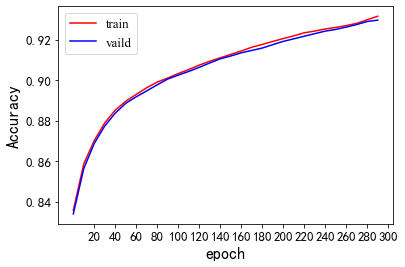

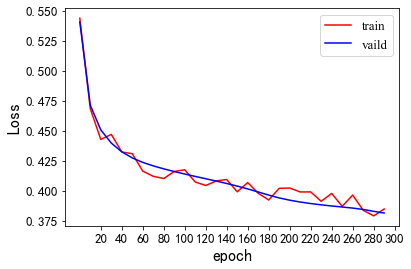

In [271]:
draw_plot(300,DNN_train_acc,DNN_vaild_acc,'Accuracy')
draw_plot(300,DNN_loss_train,DNN_loss_vaild,'Loss')

# 长短记忆

In [48]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.LSTM = nn.LSTM(22,32,num_layers=1)
        self.hidden = nn.Linear(32, 128)
        self.hidden1  = nn.Linear(128, 2)
        self.out  =  nn.Sigmoid()
    def forward(self, x):
        x,h= self.LSTM(x)
        x = self.hidden(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

In [49]:
model =LSTM()
time2 = time()
LSTM_train_acc,LSTM_vaild_acc,LSTM_loss_train,LSTM_loss_vaild=tarin_model(model)
LSTM_time = datetime.datetime.fromtimestamp(time()-time2).strftime("%M:%S:%f")
print(LSTM_time)

epoch 10,训练集 loss：0.6712640216337762,训练集acc: 0.5663909316062927,验证集 loss：0.6774829532357591,验证集 acc: 0.563545823097229
epoch 20,训练集 loss：0.6561624725162333,训练集acc: 0.59690260887146,验证集 loss：0.6552369962352238,验证集 acc: 0.5924699902534485
epoch 30,训练集 loss：0.5991314310504193,训练集acc: 0.7654208540916443,验证集 loss：0.6068706618553015,验证集 acc: 0.7621137499809265
epoch 40,训练集 loss：0.5413664682289172,训练集acc: 0.8069206476211548,验证集 loss：0.5517759023676019,验证集 acc: 0.8029463291168213
epoch 50,训练集 loss：0.5118427808523407,训练集acc: 0.8259052038192749,验证集 loss：0.5142620181188762,验证集 acc: 0.8249152898788452
epoch 60,训练集 loss：0.4949093925809394,训练集acc: 0.8431299328804016,验证集 loss：0.48893336930366466,验证集 acc: 0.8412637114524841
epoch 70,训练集 loss：0.460285268004429,训练集acc: 0.8547890186309814,验证集 loss：0.47102700454191465,验证集 acc: 0.8546093702316284
epoch 80,训练集 loss：0.4498620348205159,训练集acc: 0.8643693327903748,验证集 loss：0.458098819477689,验证集 acc: 0.8636177182197571
epoch 90,训练集 loss：0.44016349968254875,训练集ac

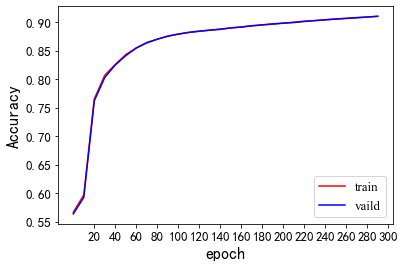

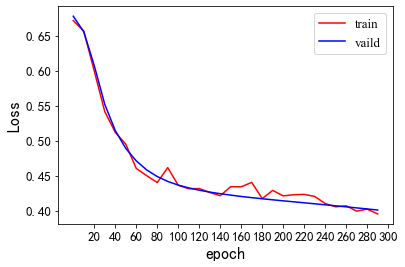

In [272]:
draw_plot(300,LSTM_train_acc,LSTM_vaild_acc,'Accuracy')
draw_plot(300,LSTM_loss_train,LSTM_loss_vaild,'Loss')

# 卷积神经网络

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv =  nn.Conv1d(1,22,4)
        self.hidden = nn.Linear(418, 256)
        self.hidden1   = nn.Linear(256, 2)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x= x.reshape([-1,1,22])
        x= self.conv(x)
        x = x.view(x.size(0),-1)
        x=  self.hidden(F.relu(x))
        x=  self.hidden1(F.relu(x))
        x=  self.out(x)

        return x

In [52]:
model =CNN()
time3 = time()
CNN_train_acc,CNN_vaild_acc,CNN_loss_train,CNN_loss_vaild=tarin_model(model)
CNN_time = datetime.datetime.fromtimestamp(time()-time3).strftime("%M:%S:%f")
print(CNN_time)

epoch 10,训练集 loss：0.4747197867453549,训练集acc: 0.8553829789161682,验证集 loss：0.4800186188925192,验证集 acc: 0.8553793430328369
epoch 20,训练集 loss：0.4241908461782708,训练集acc: 0.8739715814590454,验证集 loss：0.44760699583903746,验证集 acc: 0.8748331665992737
epoch 30,训练集 loss：0.431649340767971,训练集acc: 0.883496880531311,验证集 loss：0.4343125260165867,验证集 acc: 0.8831998705863953
epoch 40,训练集 loss：0.41635227409921904,训练集acc: 0.8895353674888611,验证集 loss：0.4261556851773377,验证集 acc: 0.8897700309753418
epoch 50,训练集 loss：0.41798575209720557,训练集acc: 0.8941330313682556,验证集 loss：0.420455543824344,验证集 acc: 0.8935427665710449
epoch 60,训练集 loss：0.3997071689338179,训练集acc: 0.8980377316474915,验证集 loss：0.4162536609515296,验证集 acc: 0.8970588445663452
epoch 70,训练集 loss：0.41765742410591244,训练集acc: 0.9008975028991699,验证集 loss：0.41292084415985003,验证集 acc: 0.9001386165618896
epoch 80,训练集 loss：0.4214422054104918,训练集acc: 0.9035923480987549,验证集 loss：0.4100484712346259,验证集 acc: 0.9030900597572327
epoch 90,训练集 loss：0.4051910850971747,训

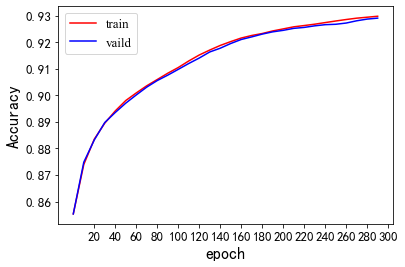

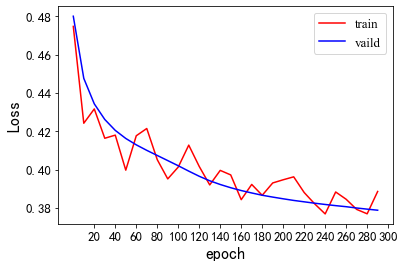

In [273]:
draw_plot(300,CNN_train_acc,CNN_vaild_acc,'Accuracy')
draw_plot(300,CNN_loss_train,CNN_loss_vaild,'Loss')

# 各模型准确率分析

In [280]:
def bar(y1,y2,xticks):
    #fig = plt.figure(figsize=(5, 5))
#     plt.rcParams['font.family'] = 'simhei'
   # plt.title('双柱状图', fontsize=15)
    plt.bar(np.arange(len(y1)), y1, width=0.4, color='tomato', label='train')
    for x, y in enumerate(y1):
        plt.text(x-0.15, y+0.04, round(y.item(),3),fontsize=12)
        
    plt.bar(np.arange(len(y2)) + 0.4, y2, width=0.4, color='steelblue', label='test')
    for x, y in enumerate(y2):
        plt.text(x + 0.23, y+0.04, round(y.item(),3),fontsize=12)
        
    plt.xticks(np.arange(len(xticks))+0.2 , xticks,fontsize=15)
    plt.yticks(np.arange(0,1.3,0.1) , [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,"","",""],fontsize=13)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend(loc='upper left')
    plt.show()


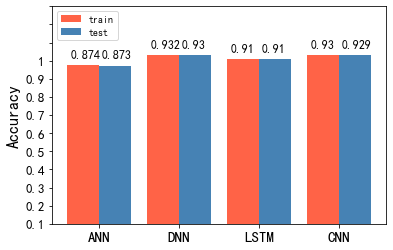

In [281]:
train_acc = [max(ANN_train_acc),max(DNN_train_acc),max(LSTM_train_acc),max(CNN_train_acc)]
vaild_acc = [max(ANN_vaild_acc),max(DNN_vaild_acc),max(LSTM_vaild_acc),max(CNN_vaild_acc)]
xticks = ['ANN', 'DNN', 'LSTM', 'CNN']
bar(train_acc,vaild_acc,xticks)
